## 계층적 멀티 에이전트 팀(Hierarchial Agent Team)

시스템에 더 많은 에이전트를 추가하면 슈퍼바이저가 모든 에이전트를 관리하기 너무 어려워질 수 있습니다. 슈퍼바이저가 다음에 호출할 에이전트에 대해 잘못된 결정을 내리기 시작하거나, 단일 슈퍼바이저가 추적하기에는 컨텍스트가 너무 복잡해질 수 있습니다. 즉, 애초에 멀티 에이전트 아키텍처를 채택하게 된 것과 동일한 문제가 발생하게 됩니다.

이를 해결하기 위해 시스템을 **계층적으로** 설계할 수 있습니다. 예를 들어, 개별 슈퍼바이저가 관리하는 전문화된 에이전트 팀을 별도로 만들고, 최상위 슈퍼바이저가 팀을 관리하도록 할 수 있습니다.

- 참고 자료: https://wikidocs.net/270691
- 관련 논문: https://arxiv.org/abs/2308.08155

## 환경 설정

In [1]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

In [46]:
# 스트리밍 에이전트 출력을 깔끔하게 렌더링하기 위해
# pretty_print_messages 헬퍼를 사용할 것입니다
from langchain_core.messages import convert_to_messages


def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)


def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update.get("messages", []))
        if messages and len(messages) > 0 and last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

## 리서치 팀(Research Team)

리서치 팀은 `search agent`와 `research_agent`라는 두 개의 작업자를 가집니다. 작업자 에이전트를 생성하고 팀 슈퍼바이저를 생성합니다.

### 리서치 도구

In [3]:
from langchain_tavily import TavilySearch

# 웹 검색 도구 정의
web_search_tool = TavilySearch(max_results=5)

In [ ]:
# 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
from typing import List
from langchain_core.tools import tool
from langchain_community.document_loaders import WebBaseLoader


@tool
def scrape_webpages(urls: List[str]):
    """제공된 웹 페이지에서 상세 정보를 추출하기 위해 사용하십시오."""

    loader = WebBaseLoader(
        web_paths=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) Chrome/110",
        },
    )
    docs = loader.load()

    return "\n".join(
        [
            f'<Document source="{doc.metadata.get("source", "")}" title="{doc.metadata.get("title", "")}">{doc.page_content}</Document>'
            for doc in docs
        ]
    )


In [ ]:
scrape_webpages.invoke(
    input={"urls": ["https://langchain-ai.github.io/langgraph/concepts/multi_agent/"]}
)

'<Document source="https://langchain-ai.github.io/langgraph/concepts/multi_agent/" title="Overview">\n\n\n\n\n\n\n\n\n\n\n\nOverview\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n          Skip to content\n        \n\n\n\n\n\n\n\n            \n            \nThese docs will be deprecated and removed with the release of LangGraph v1.0 in October 2025. Visit the v1.0 alpha docs\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            LangGraph\n          \n\n\n\n            \n              Overview\n            \n          \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n            Initializing search\n          \n\n\n\n\n\n\n\n\n\n\n\n\n    GitHub\n  \n\n\n\n\n\n\n\n\n\n\n          \n  \n  \n    \n  \n  Get started\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Guides\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Reference\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Examples\n\n        \n\n\n\n          \n  \n  \n    \n  \n  Additional res

### 리서치팀 그래프 상태 정의

In [27]:
from typing import Annotated
from langgraph.graph.message import MessagesState


class ResearchState(MessagesState):
    team_members: Annotated[list[str], "팀원 에이전트 목록"]
    next_agent: Annotated[str, "다음 작업자"]

## 에이전트 노드 생성

In [55]:
from typing import Literal
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.graph.state import CompiledStateGraph
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableSerializable


# 에이전트 노드 생성 함수
def create_agent_node(agent: CompiledStateGraph | RunnableSerializable):
    def agent_node(state):
        response = agent.invoke(state)
        answer = response["messages"][-1].content
        return {"messages": [HumanMessage(content=answer, name=agent.name)]}

    return agent_node


# 슈퍼파이저 에이전트 생성 함수
def create_team_supervisor(model_name, system_prompt, members: list[str]):
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next_agent = ["FINISH"] + members

    class RouteResponse(BaseModel):
        """
        워크플로우 라우팅 응답 모델

        현재 에이전트가 작업을 완료한 후, 다음에 실행될 에이전트를 결정하거나
        전체 워크플로우를 종료하기 위한 응답 모델입니다.
        """

        next_agent: Annotated[
            Literal[*options_for_next_agent],
            Field(
                ...,
                description="다음으로 라우팅할 에이전트의 이름 또는 'FINISH'를 지정합니다. "
                "사용 가능한 값:\n"
                "- 에이전트 이름: 해당 에이전트로 작업을 전달\n"
                "- 'FINISH': 모든 작업이 완료되어 워크플로우를 종료\n"
                "현재 작업 상태와 요구사항을 기반으로 가장 적합한 다음 단계를 선택하세요.",
            ),
        ]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt
                + "\nGiven the conversation above, who should act next agent? "
                "\nOr should we FINISH? Select one of: {options}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    ).partial(options=", ".join(options_for_next_agent))

    llm = ChatOpenAI(model=model_name, temperature=0)

    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    def supervisor(state: ResearchState):
        response = supervisor_chain.invoke(state["messages"])
        return {"next_agent": response.next_agent}

    return supervisor


# 검색 에이전트
search_agent = create_react_agent(
    "openai:gpt-4.1-mini", tools=[web_search_tool], name="Searcher"
)
search_node = create_agent_node(search_agent)

# 웹 스크래핑 노드
web_scraping_agent = create_react_agent(
    "openai:gpt-4.1-mini", tools=[scrape_webpages], name="WebScraper"
)
web_scraping_node = create_agent_node(web_scraping_agent)

# Supervisor 에이전트
research_supervisor = create_team_supervisor(
    "gpt-4.1-mini",
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

### 리서치팀 그래프 생성

In [56]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver


def get_next_node(state: ResearchState):
    return state["next_agent"]


research_builder = StateGraph(ResearchState)

research_builder.add_node("Searcher", search_node)
research_builder.add_node("WebScraper", web_scraping_node)
research_builder.add_node("Supervisor", research_supervisor)

research_builder.add_edge("Searcher", "Supervisor")
research_builder.add_edge("WebScraper", "Supervisor")
research_builder.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "Searcher": "Searcher",
        "WebScraper": "WebScraper",
        "FINISH": END,
    },
)

research_builder.set_entry_point("Supervisor")

research_graph = research_builder.compile(checkpointer=MemorySaver())


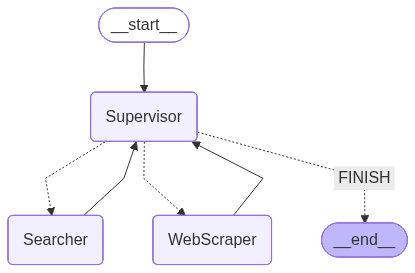

In [57]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [58]:
from langgraph.graph.state import CompiledStateGraph
from langchain_core.runnables import RunnableConfig
from random import random


def run_graph(graph: CompiledStateGraph, message: str, recursive_limit: int = 50):
    config = RunnableConfig(
        recursion_limit=recursive_limit, configurable={"thread_id": random()}
    )

    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    for chunk in graph.stream(inputs, config):
        pretty_print_messages(chunk)

    return graph.get_state(config).values

In [59]:
output = run_graph(
    research_graph,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

Update from node Supervisor:




Update from node WebScraper:


================================ Human Message =================================
Name: WebScraper

네이버 금융 뉴스 주요 뉴스 정리:

1. 반도체 실적 기대 vs 미중·셧다운 리스크 [주간증시전망] (파이낸셜뉴스)
2. 양자컴퓨팅 ETF 20%대 급등..중국 테크 일제히 약세 [ETF 스퀘어] (파이낸셜뉴스)
3. “이러니 주가 안오를 수 있겠나”…AI·코인 다 가진 ‘이 기업’ 한달새 78% 급등 (매일경제)
4. 트럼프 ‘암초’ 천당·지옥 오간 비트코인…“중국 추가 보복이 관건” [가상자산 나침반] (디지털타임스)
5. 닛케이 4만8000선 돌파 '다카이치 랠리'...일본 반도체 ETF 20% 급등 (이데일리)
6. 일본 ‘메타플래닛’·홍콩 ‘문’…아시아판 스트래티지 만든다는 이 남자의 전략 (매일경제)
7. "1억으로 한 달 만에 3000만원 벌었어요"…개미들 신났다 [종목+] (출처 언론 미상)
8. 금·은 투자 과열주의보…골드뱅킹 잔액 1.5조 돌파 (출처 언론 미상)
9. 우리WON뱅킹앱, 이달 말까지 최고 연 7% 적금…32종 특판·서비스 마련 (출처 언론 미상)
10. [이런펀드어때요?] 신한운용 'SOL AI반도체 소부장 ETF' (출처 언론 미상)

출처: https://finance.naver.com/news


Update from node Supervisor:






In [48]:
print(output["messages"][-1].content)

네이버 금융 뉴스 주요 뉴스 정리입니다:

1. 반도체 실적 기대 vs 미중·셧다운 리스크 [주간증시전망]
2. 양자컴퓨팅 ETF 20%대 급등..中 테크 일제히 약세 [ETF 스퀘어]
3. “이러니 주가 안오를 수 있겠나”…AI·코인 다 가진 ‘이 기업’ 한달새 78% 급등
4. 트럼프 ‘암초’ 천당·지옥 오간 비트코인…“중국 추가 보복이 관건” [가상자산 나침반]
5. 닛케이 4만8000선 돌파 '다카이치 랠리'...日 반도체 ETF 20% 급등
6. 일본 ‘메타플래닛’·홍콩 ‘문’…아시아판 스트래티지 만든다는 이 남자의 전략

출처: https://finance.naver.com/news


## 문서 작성팀

### 문서 작성 도구

In [ ]:
from pathlib import Path
from typing import Dict, Optional, List
from typing_extensions import Annotated


# 작업 디렉토리
WORKING_DIRECTORY = Path("./tmp")
WORKING_DIRECTORY.mkdir(exist_ok=True)


# 아웃라인 생성 및 파일로 저장
@tool
def create_outline(
    points: Annotated[List[str], "주요 항목 또는 섹션 목록."],
    file_name: Annotated[str, "개요를 저장할 파일 경로."],
) -> Annotated[str, "저장된 개요 파일의 경로."]:
    """개요를 작성하고 저장하세요."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


# 문서 읽기
@tool
def read_document(
    file_name: Annotated[str, "문서를 읽을 파일 경로."],
    start: Annotated[Optional[int], "시작 지점. 기본값은 0입니다."] = None,
    end: Annotated[Optional[int], "끝 줄. 기본값은 없음"] = None,
) -> str:
    """지정된 문서를 읽으십시오."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    # 시작 줄이 지정되지 않은 경우 기본값 설정
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


# 문서 쓰기 및 저장
@tool
def write_document(
    content: Annotated[str, "문서에 작성될 텍스트 내용."],
    file_name: Annotated[str, "문서를 저장할 파일 경로."],
) -> Annotated[str, "저장된 문서 파일의 경로."]:
    """텍스트 문서를 생성하고 저장하십시오."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


# 문서 편집
@tool
def edit_document(
    file_name: Annotated[str, "편집할 문서의 파일 경로."],
    inserts: Annotated[
        Dict[int, str],
        "키가 줄 번호(1부터 시작)이고 값이 해당 줄에 삽입될 텍스트인 사전.",
    ],
) -> Annotated[str, "수정된 문서의 파일 경로."]:
    """특정 줄 번호에 텍스트를 삽입하여 문서를 편집합니다."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    # 삽입할 텍스트를 정렬하여 처리
    sorted_inserts = sorted(inserts.items())

    # 지정된 줄 번호에 텍스트 삽입
    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"

In [23]:
from langchain_experimental.tools import PythonREPLTool

python_repl_tool = PythonREPLTool()

In [60]:
# 상태 정의
class DocWritingState(MessagesState):
    team_members: Annotated[list[str], "팀원 에이전트 목록"]
    next_agent: Annotated[str, "다음 작업자"]
    current_files: Annotated[str, "현재 작업중인 파일"]


# 상태 전처리 노드: 각각의 에이전트가 현재 작업 디렉토리의 상태를 더 잘 인식할 수 있도록 함
def preprocess(state):
    # 작성된 파일 목록 초기화
    written_files = []

    try:
        # 작업 디렉토리 내의 모든 파일을 검색하여 상대 경로로 변환
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    # 작성된 파일이 없으면 상태에 "No files written." 추가
    if not written_files:
        return {**state, "current_files": "No files written."}

    # 작성된 파일 목록을 상태에 추가
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


# 문서 작성 에이전트 생성
doc_writer_agent = create_react_agent(
    "openai:gpt-4.1-mini",
    tools=[write_document, edit_document, read_document],
    prompt="당신은 아카이브 연구원입니다. 당신의 임무는 주어진 주제/자료에 대해 아카이브 스타일의 논문을 작성하는 것입니다.",
    name="DocWriter",
)
context_aware_doc_writer_agent = preprocess | doc_writer_agent
doc_writing_node = create_agent_node(context_aware_doc_writer_agent)

# 노트 작성 노드
note_taking_agent = create_react_agent(
    "openai:gpt-4.1-mini",
    tools=[create_outline, read_document],
    prompt="당신은 연구 논문 개요 작성의 전문가입니다. 당신의 임무는 주어진 주제/자료 또는 문서에 대한 개요를 작성하는 것입니다.",
    name="NoteTaker",
)
context_aware_note_taking_agent = preprocess | note_taking_agent
note_taking_node = create_agent_node(context_aware_note_taking_agent)


# 차트 생성 에이전트 생성
chart_generating_agent = create_react_agent(
    "openai:gpt-4.1-mini",
    tools=[read_document, python_repl_tool],
    name="ChartGenerator",
)
context_aware_chart_generating_agent = preprocess | chart_generating_agent
chart_generating_node = create_agent_node(context_aware_chart_generating_agent)

# 문서 작성 팀 감독자 생성
doc_writing_supervisor = create_team_supervisor(
    "gpt-4.1-mini",
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  ['DocWriter', 'NoteTaker', 'ChartGenerator']. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)


In [61]:
# 그래프 생성
authoring_builder = StateGraph(DocWritingState)

authoring_builder.add_node("DocWriter", doc_writing_node)
authoring_builder.add_node("NoteTaker", note_taking_node)
authoring_builder.add_node("ChartGenerator", chart_generating_node)
authoring_builder.add_node("Supervisor", doc_writing_supervisor)

authoring_builder.add_edge("DocWriter", "Supervisor")
authoring_builder.add_edge("NoteTaker", "Supervisor")
authoring_builder.add_edge("ChartGenerator", "Supervisor")
authoring_builder.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)
authoring_builder.set_entry_point("Supervisor")

authoring_graph = authoring_builder.compile(checkpointer=MemorySaver())

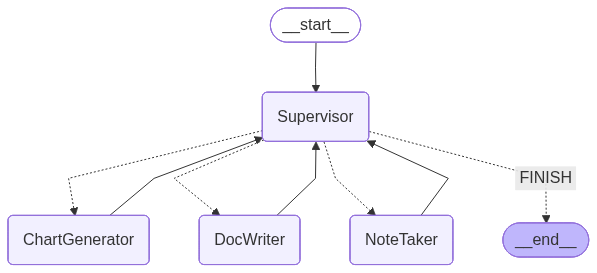

In [62]:
from IPython.display import Image, display

display(Image(authoring_graph.get_graph().draw_mermaid_png()))

Update from node Supervisor:




Update from node DocWriter:


================================ Human Message =================================

Transformer 구조에 대한 심층 분석 논문의 목차 및 각 목차별 상세 내용을 작성하였습니다. 최종 분석 논문은 'transformer_full_paper.txt'에 저장되어 있습니다. 필요하신 경우 이 파일을 열어 내용을 확인하실 수 있습니다.


Update from node Supervisor:




Update from node ChartGenerator:


================================ Human Message =================================

Transformer의 구조에 대한 심층 분석 논문의 목차와 각 목차별 상세 내용을 아래와 같이 정리했습니다.

1. 서론
Transformer는 자연어 처리 분야에 혁신을 가져온 딥러닝 모델로, 병렬 처리를 지원하고 긴 거리의 의존 관계를 효과적으로 모델링할 수 있습니다. 기존의 RNN이 가지고 있던 순차적 처리 한계를 극복하여 효율성과 성능을 동시에 향상시켰습니다. 이 논문에서는 Transformer의 구조를 깊이 있게 분석하여 모델의 원리부터 응용까지 폭넓게 다루고자 합니다. Transformer의 핵심 메커니즘과 구성요소를 이해하는 것은 다양한 데이터 처리 문제를 해결하는 데 중요합니다. 아울러 향후 연구 방향에 대해서도 조명합니다.

2. Transformer의 기본 개념
Transformer는 어텐션 메커니즘을 기반으로 한 신경망 모델로, 시퀀스 데이터를 병렬로 처리할 수 있어 학습 속도가 매우 빠릅니다. 전체 입력을 동시에 고려하여 긴 문맥 정보를 효과적으로 포착하며, 인코더와 디코더 두 부분으로 구성됩니다. 각 부분은 입력을 잠재 표현으로 변환하거나 출력 시퀀스를 생성하는 역할

Python REPL can execute arbitrary code. Use with caution.
<string>:15: UserWarning: Glyph 51473 (\N{HANGUL SYLLABLE JUNG}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
<string>:15: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING

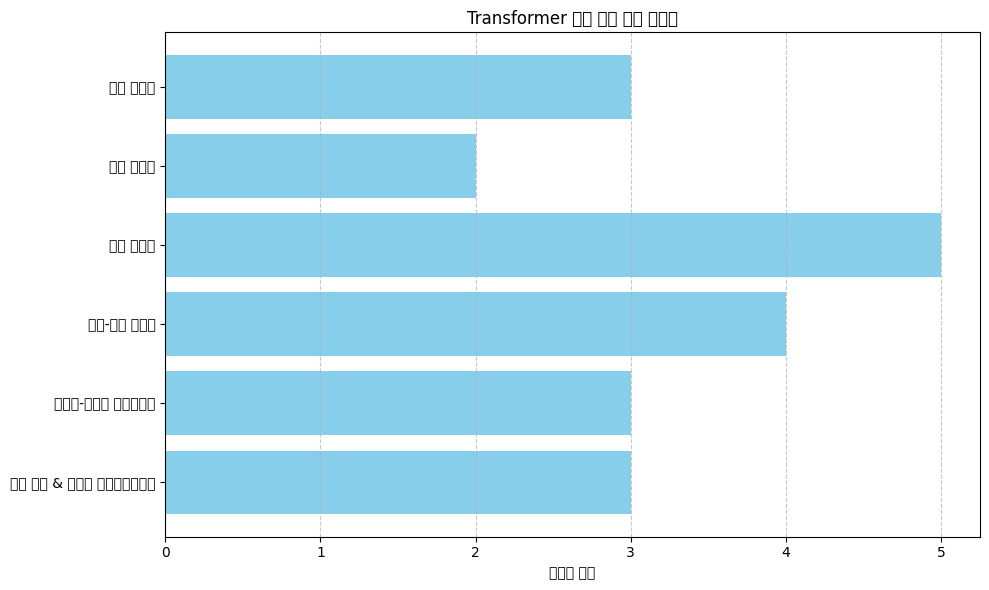

Update from node ChartGenerator:


================================ Human Message =================================

Transformer 구조의 핵심 구성 요소 중요도 차트를 생성하여 시각적으로 나타냈습니다. 차트는 입력 임베딩, 위치 인코딩, 셀프 어텐션, 멀티-헤드 어텐션, 포지션-와이즈 피드포워드, 잔차 연결 및 레이어 노멀라이제이션의 중요도를 비교합니다. 생성한 차트는 'transformer_core_components_chart.png' 파일로 저장되어 있습니다. 필요에 따라 이 이미지를 참고하여 각 구성 요소의 역할과 중요성을 명확히 이해할 수 있습니다. 논문의 시각적 자료로 활용하기 적합합니다.


Update from node Supervisor:






In [63]:
output = run_graph(
    authoring_graph,
    "Transformer 의 구조에 대해서 심층 파악해서 논문의 목차를 한글로 작성해줘. "
    "그 다음 각각의 목차에 대해서 5문장 이상 작성해줘. "
    "상세내용 작성시 만약 chart 가 필요하면 차트를 작성해줘. "
    "최종 결과를 저장해줘. ",
)